In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
lineage_order = [
#     "driver::send", 
                     "clipper::frontend_rpc_recv", 
                     "clipper::task_enqueued", 
                     "clipper::task_dequeued", 
                     "clipper::sent_rpc", 
                     "container::recv",
                     "container::send", 
                     "clipper::rpc_recv", 
                     "clipper::task_executor_recv", 
#                      "clipper::zmq_frontend_response_callback", 
#                      "clipper::frontend_rpc_response_send", 
                        "clipper::frontend_rpc_send"
#                      "driver::recv"
]

points_to_include = [
    "clipper::frontend_rpc_recv", 
    "clipper::task_enqueued",
#     "clipper::task_dequeued",
#     "clipper::sent_rpc",
#     "container::recv",
    "container::send",
#     "clipper::rpc_recv",    
#     "clipper::task_executor_recv",
    "clipper::frontend_rpc_send",
#     "clipper::frontend_rpc_response_send",
#     "driver::recv"
]

# def extract_lineage(lineage):
#     first_key = "driver::send"
# #     first_key = "clipper::frontend_rpc_recv"
# #     first_key = "clipper::task_dequeued"
# #     first_key = "container::send"

#     keys = lineage[0].keys()
#     extracted = {k: [] for k in lineage[0].keys()}
#     for entry in lineage:
#         start_timestamp = entry[first_key]
#         for k, v in entry.items():
#             if k != first_key and v > start_timestamp:
#                 extracted[k].append(float(v - start_timestamp) / 1000.0)
#     return extracted

def extract_lineage_deltas(lineage):
#     first_key = "driver::send"
    first_key = "clipper::frontend_rpc_recv"
#     first_key = "clipper::task_dequeued"
#     first_key = "container::send"

    keys = lineage[0].keys()
    extracted = {k: [] for k in lineage[0].keys()}
    for entry in lineage:
        for i in range(1,len(lineage_order)):
            k = lineage_order[i]
            previous_timestamp = entry[lineage_order[i-1]]
            delta = entry[k] - previous_timestamp
            extracted[k].append(float(delta) / 1000.0)
    return extracted



def analyze_lineage(path):
    with open(path, "r") as f:
        results = json.load(f)
    

    extracted_lineage = extract_lineage_deltas(results["steady_results"]["lineage"])
    for k in lineage_order:
        v = extracted_lineage[k]
        if len(v) > 0:
            if k in points_to_include:
                fig, (ax_scatter, ax_hist) = plt.subplots(ncols=2, figsize=(20,6))
                ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.4, label=k)
                ax_scatter.legend(loc=0)
                ax_scatter.set_ylabel("Time (ms)")
    #             ax_hist.hist(v, 50, label=k, normed=1, histtype='step', cumulative=False,)
                ax_hist.hist(v, 100, label=k, normed=True, histtype='bar', cumulative=False, log=True)
                xmax = ax_hist.get_xlim()[1]
                ax_hist.set_xlim(right=max(10, xmax))
                ax_hist.set_xlabel("Time (ms)")
                ax_hist.set_ylabel("Query ID")
                ax_hist.set_ylabel("Count (normalized)")
                ax_hist.grid(b=True, which="both")
                fig.suptitle(k, fontsize=20)
                plt.show()

def analyze_dir(path, gcp=False):
    fs = list(os.listdir(path))
    fs = sorted(fs)
    for f in fs:
        if f[-4:] == "json":
            splits = f.split("-")
            if gcp:
                batch = int(splits[9])
                model = "-".join(splits[5:8])
            else:
                batch = int(splits[5])
                model = "-".join(splits[4:7])
            if model == "tf-kernel-svm":
                continue
            display(Markdown("# Model: {m}, Batch size: {b}".format(m=model, b=batch)))
            try:
                analyze_lineage(os.path.join(path, f))
            except KeyError:
                pass

# GCP Results

In [ ]:
path = os.path.abspath("../results_cpp_benchmarker/query_lineage/gcp_query_lineage_debug/")
analyze_dir(path, gcp=True)

# AWS Results

In [4]:
path = os.path.abspath("../results_cpp_benchmarker/query_lineage/query_lineage_debugging_no_double_buffer")
analyze_dir(path)

ValueError: invalid literal for int() with base 10: 'kernel'

# TF Resnet

In [6]:
fpath = os.path.abspath("../results_cpp_benchmarker/query_lineage/query_lineage_debugging_no_double_buffer/cpp-aws-results-k80-tf-resnet-feats-batch-32-180316_234839.json")
analyze_lineage(fpath)

KeyError: 'clipper::frontend_rpc_send'

# Model: batch-1-180316_191046.json, Batch size: 1

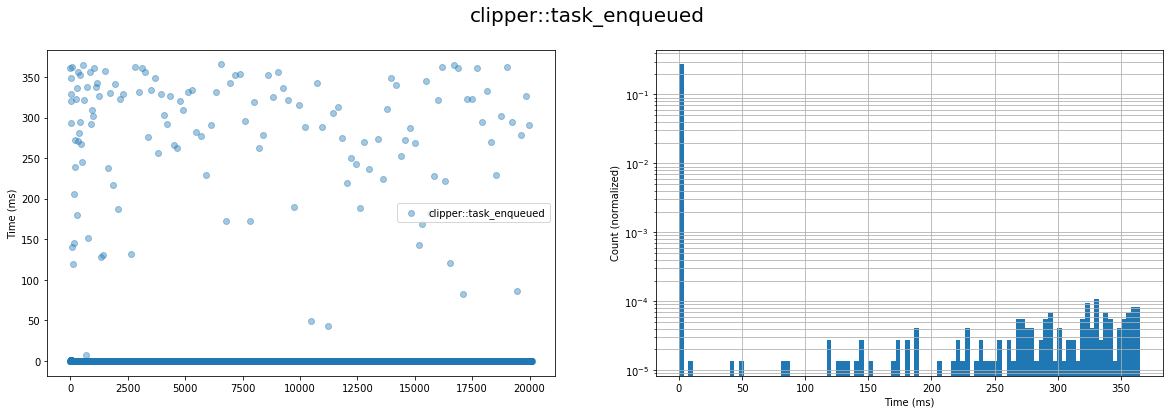

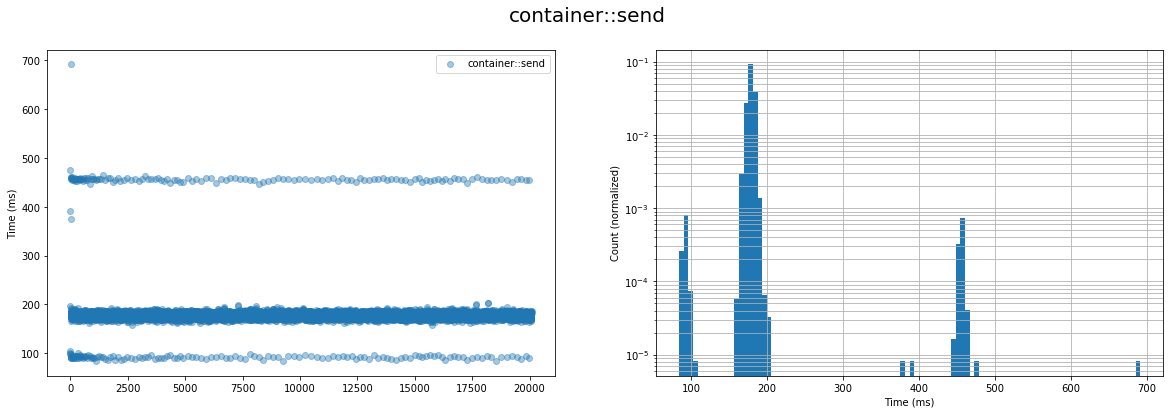

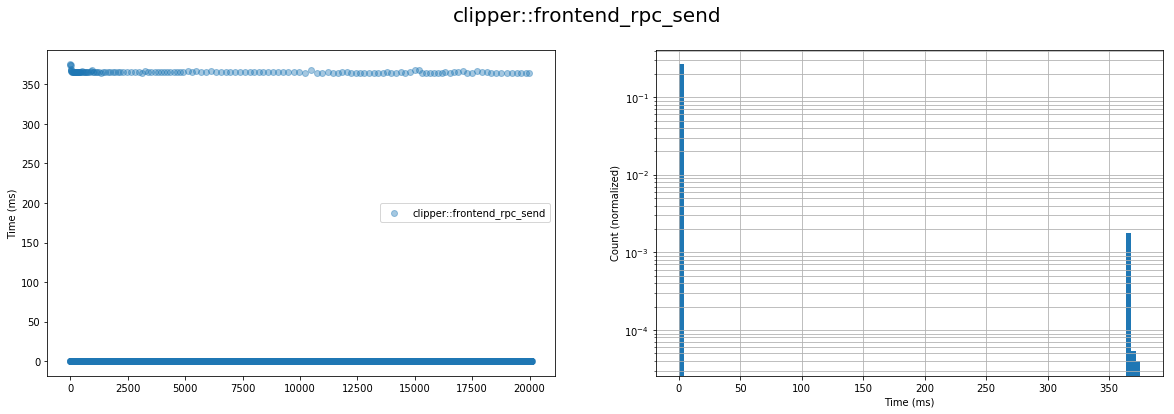

# Model: batch-16-180316_161948.json, Batch size: 16

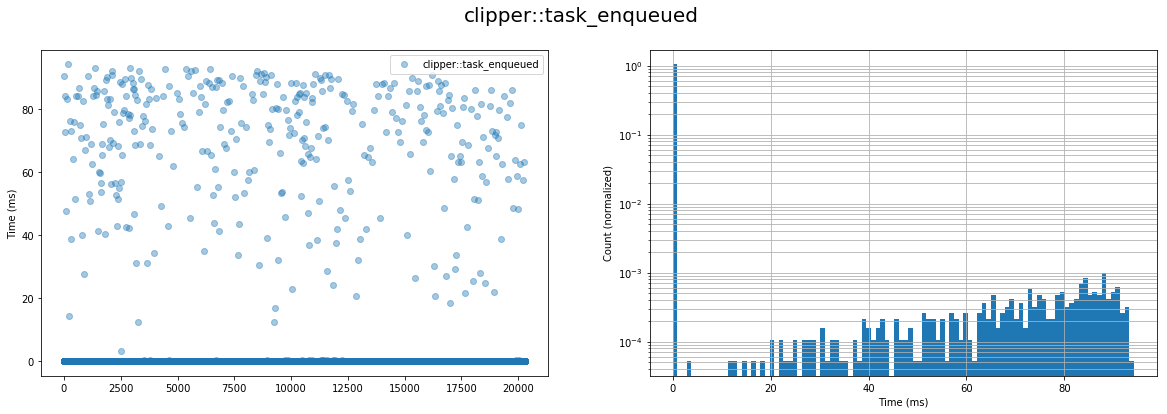

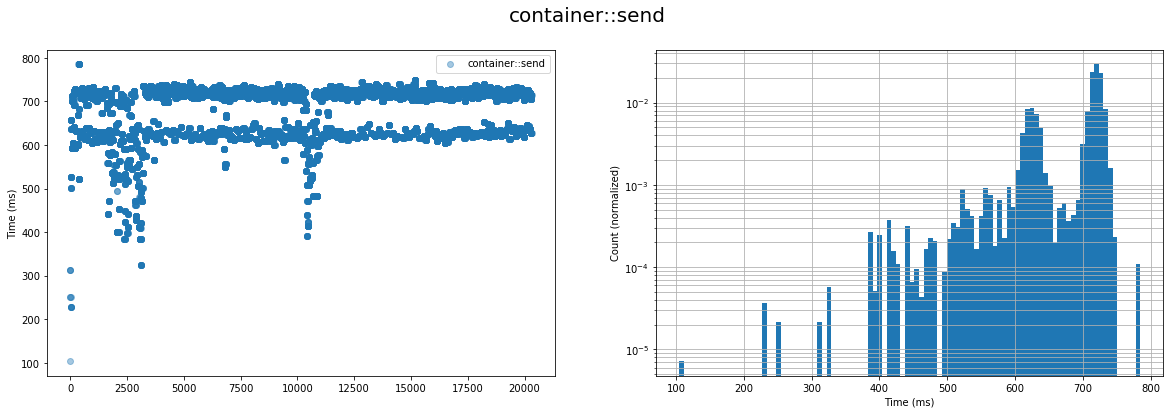

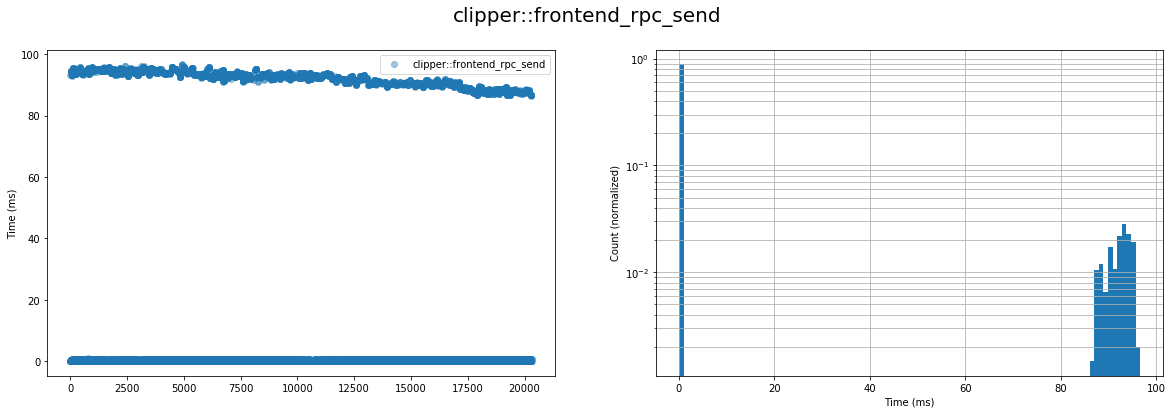

# Model: batch-24-180316_164320.json, Batch size: 24

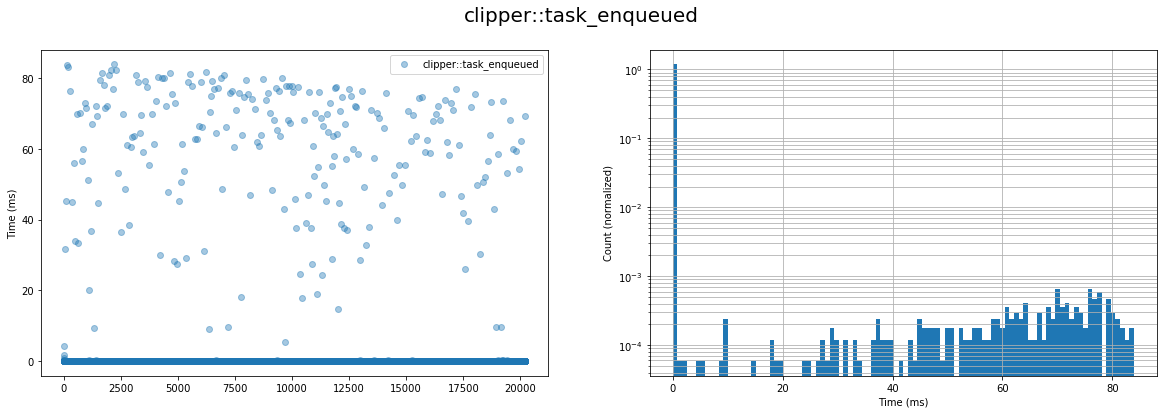

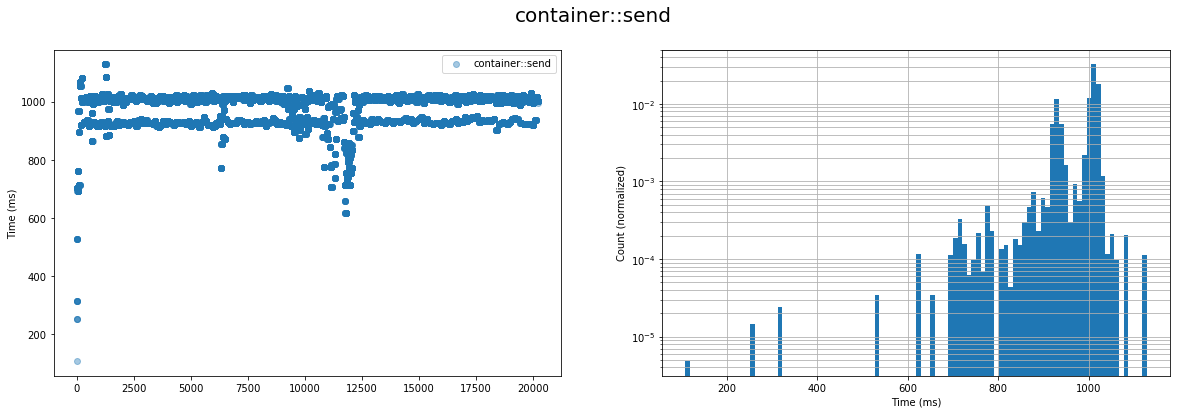

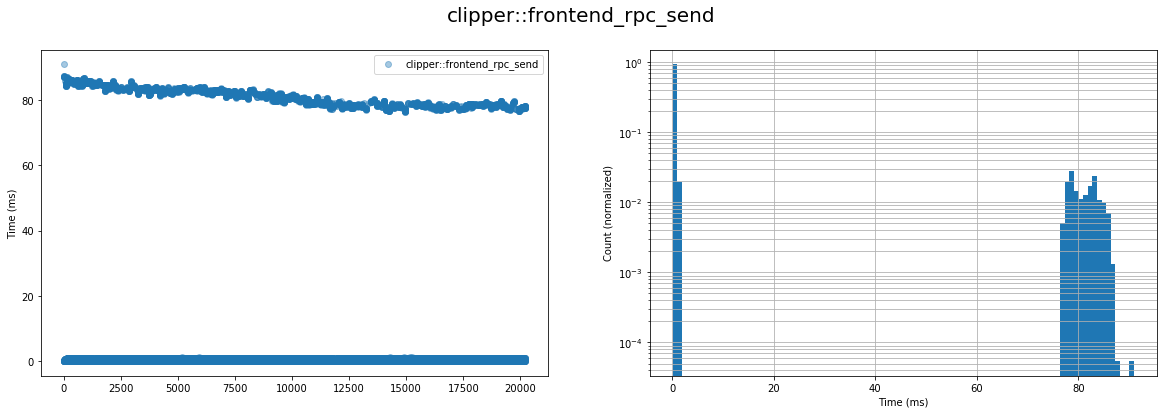

# Model: batch-32-180316_170536.json, Batch size: 32

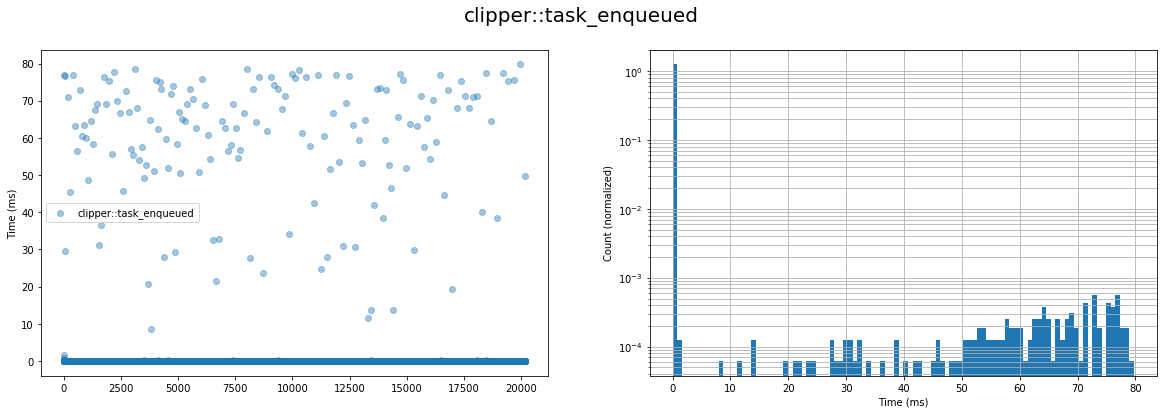

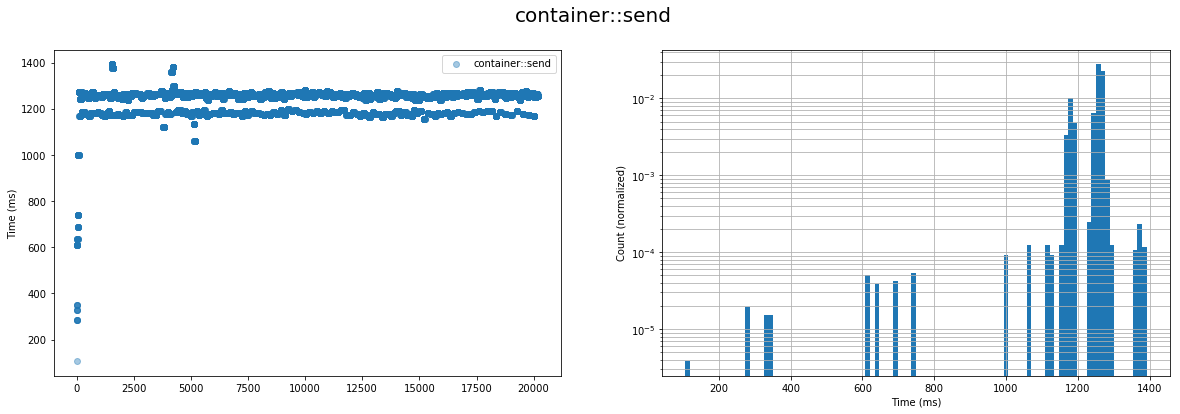

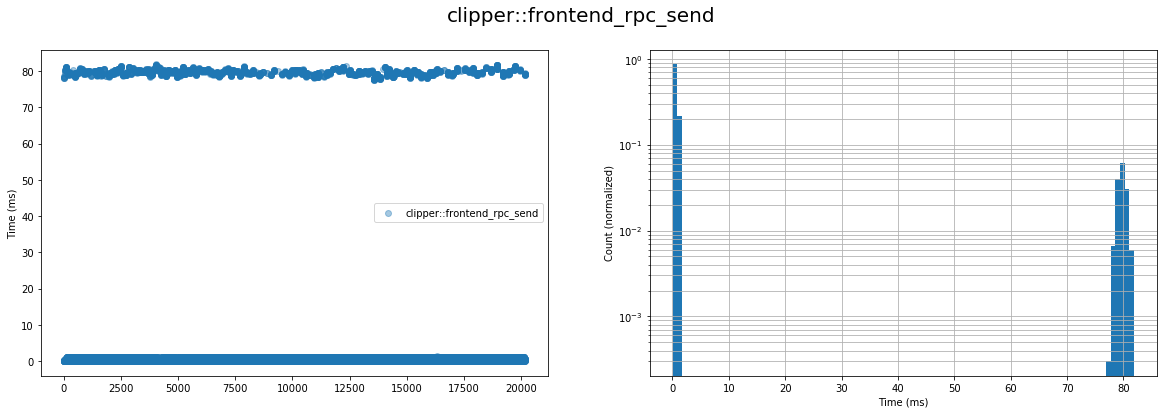

# Model: batch-4-180316_082428.json, Batch size: 4

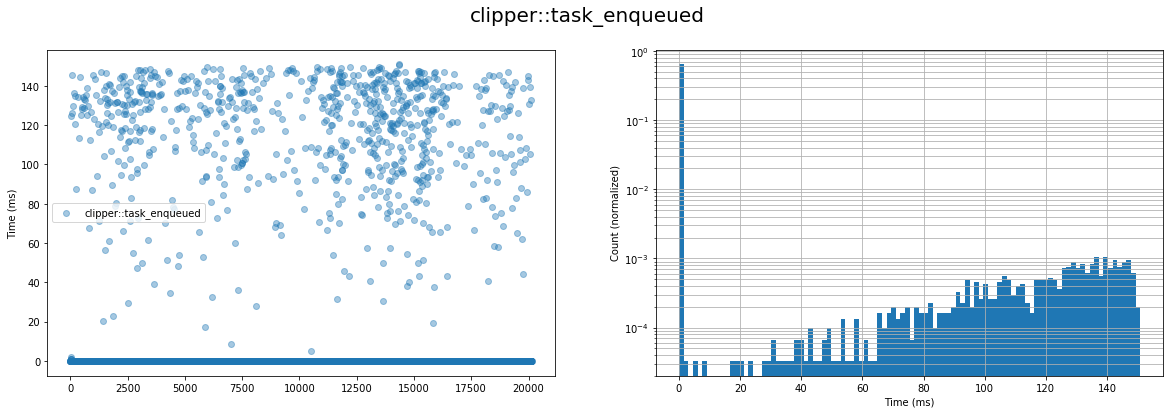

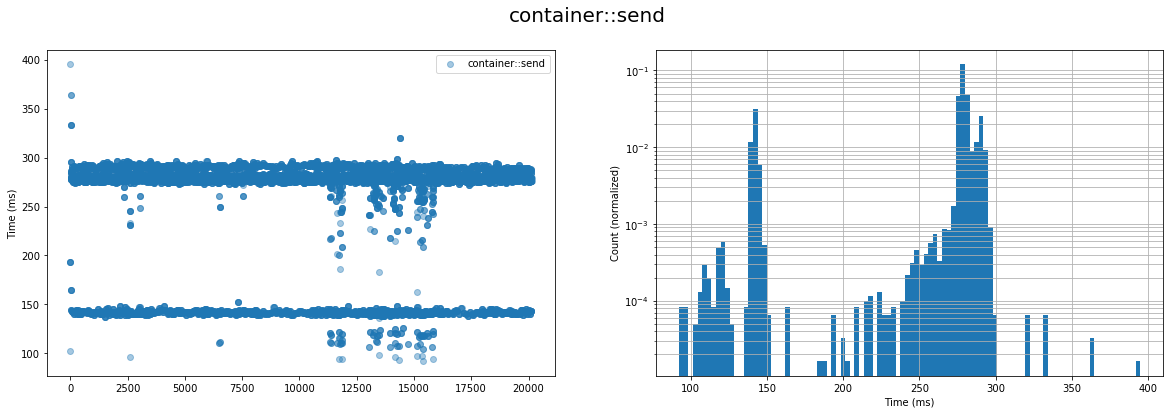

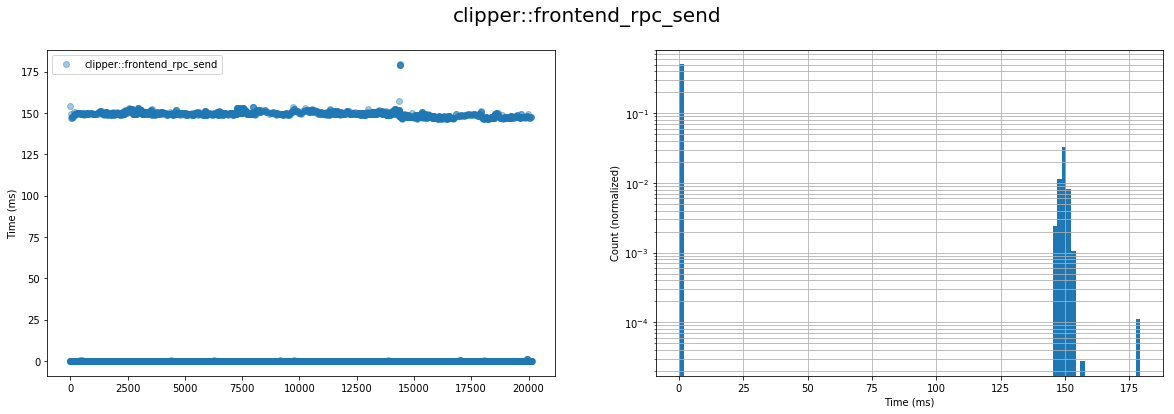

# Model: batch-48-180316_172716.json, Batch size: 48

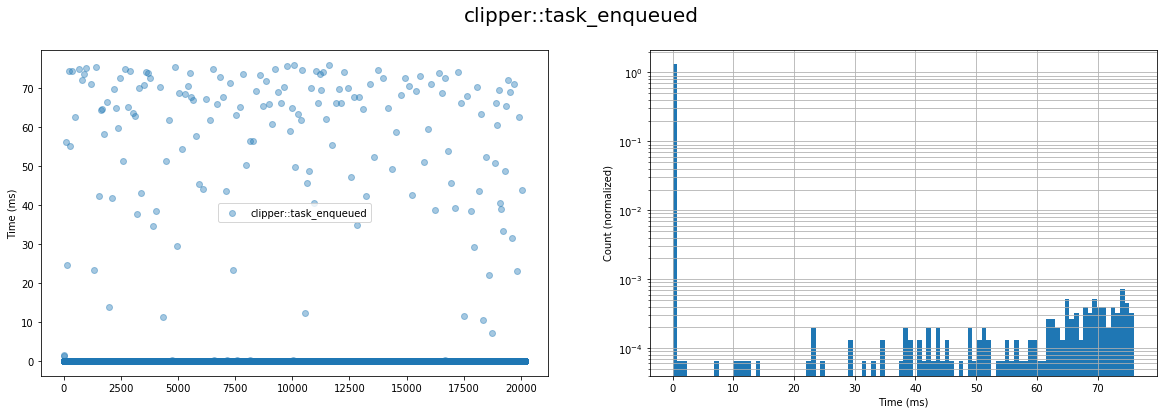

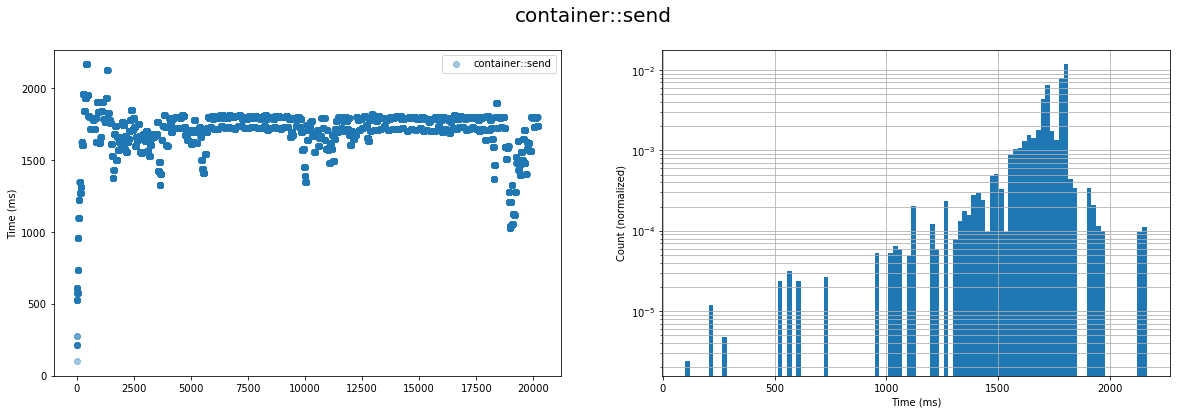

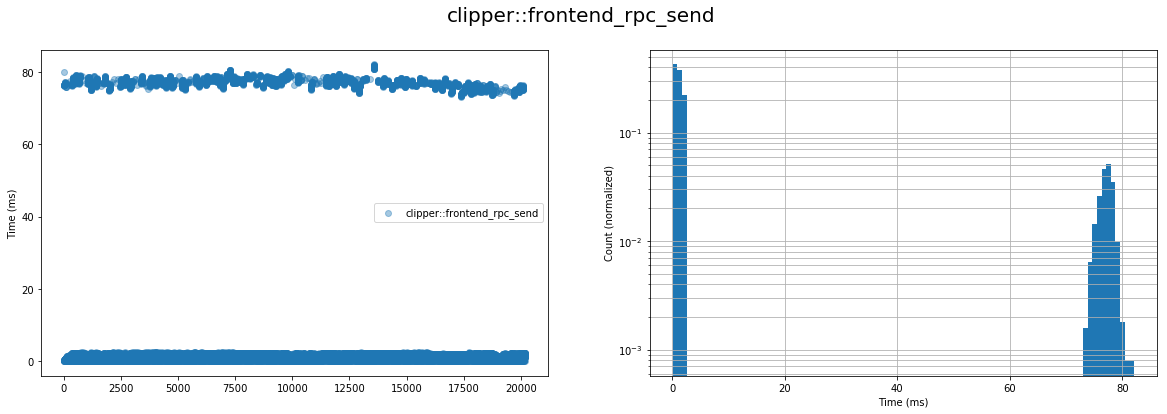

# Model: batch-64-180316_174827.json, Batch size: 64

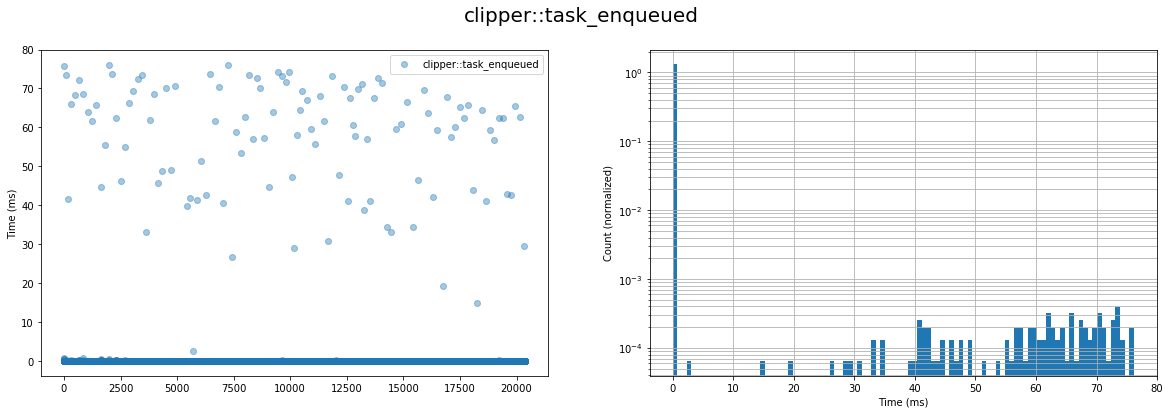

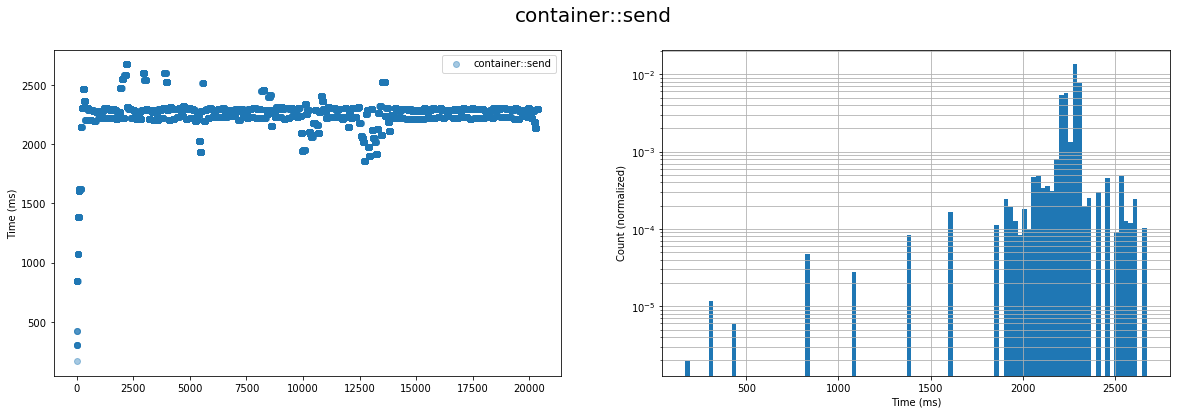

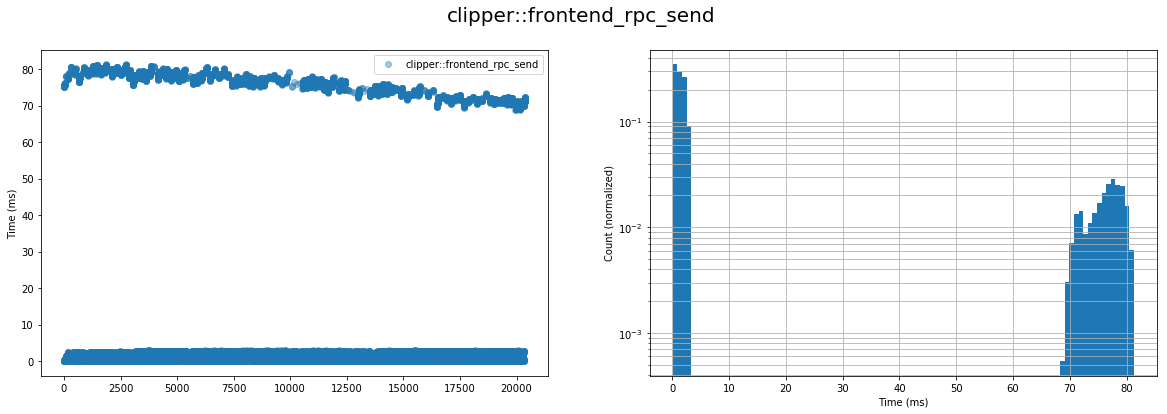

# Model: batch-8-180316_155430.json, Batch size: 8

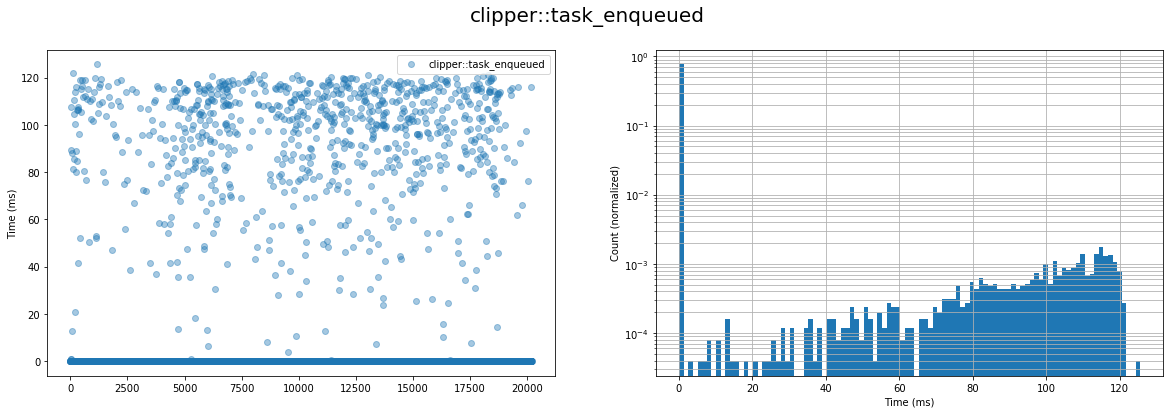

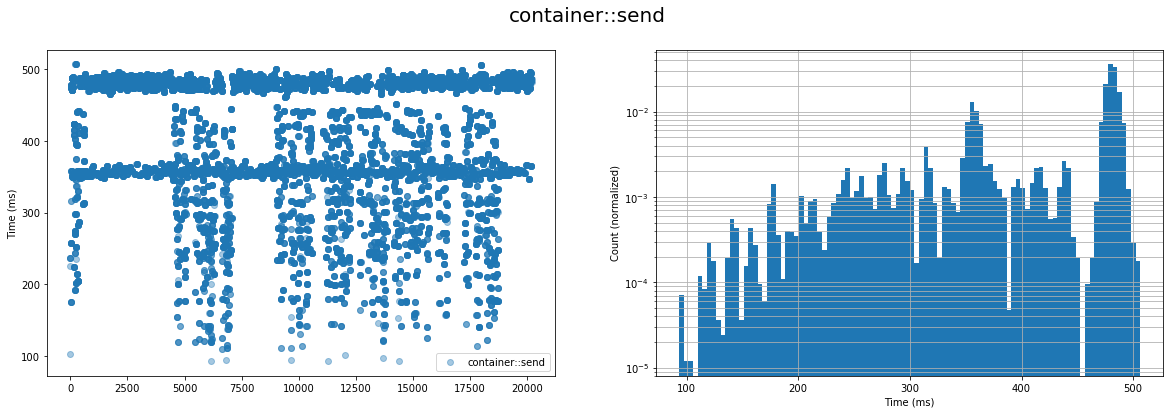

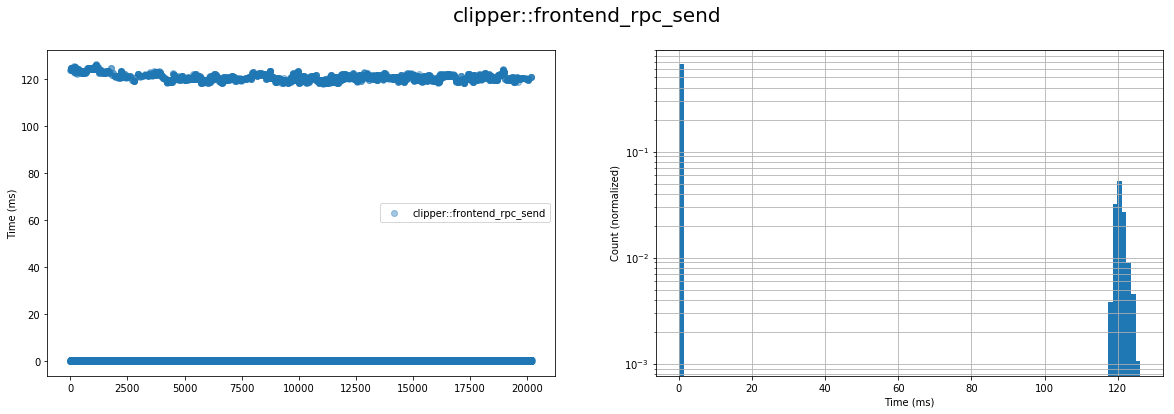

In [7]:
path = os.path.abspath("../results_cpp_benchmarker/query_lineage/query_lineage_tf-resnet-feats_smp_aws_cpp_profiling")
analyze_dir(path)

# TF Kernel SVM

# Model: batch-1-180316_191944.json, Batch size: 1

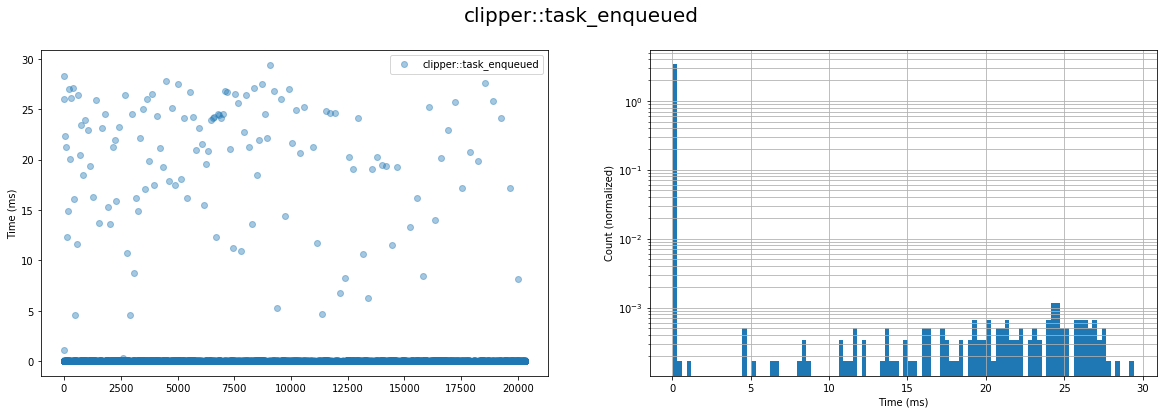

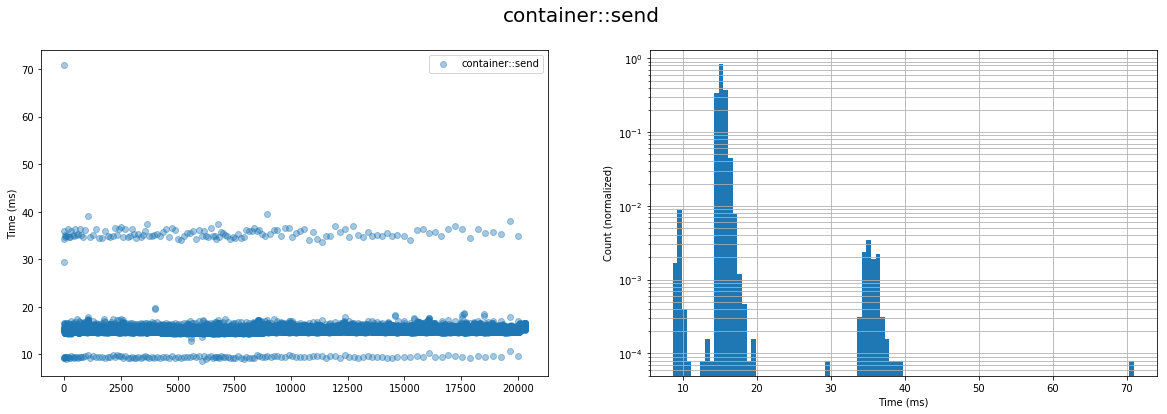

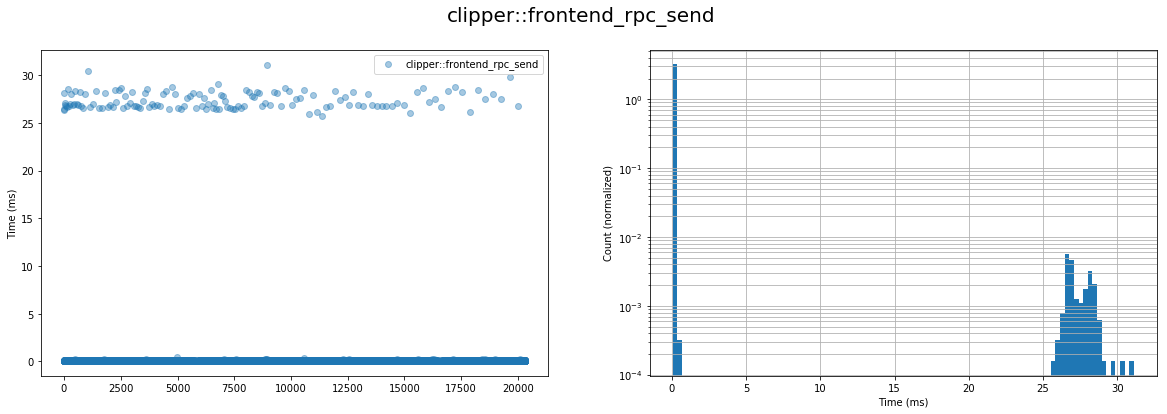

# Model: batch-16-180316_162259.json, Batch size: 16

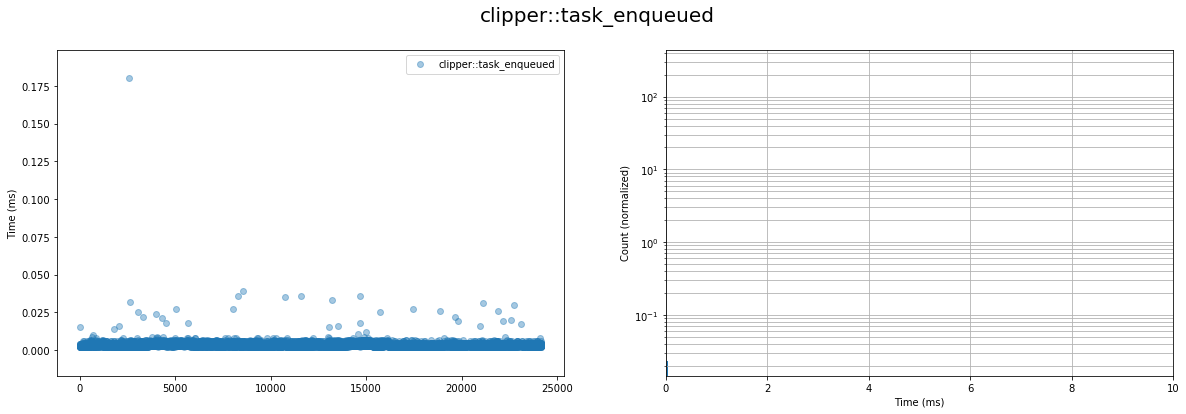

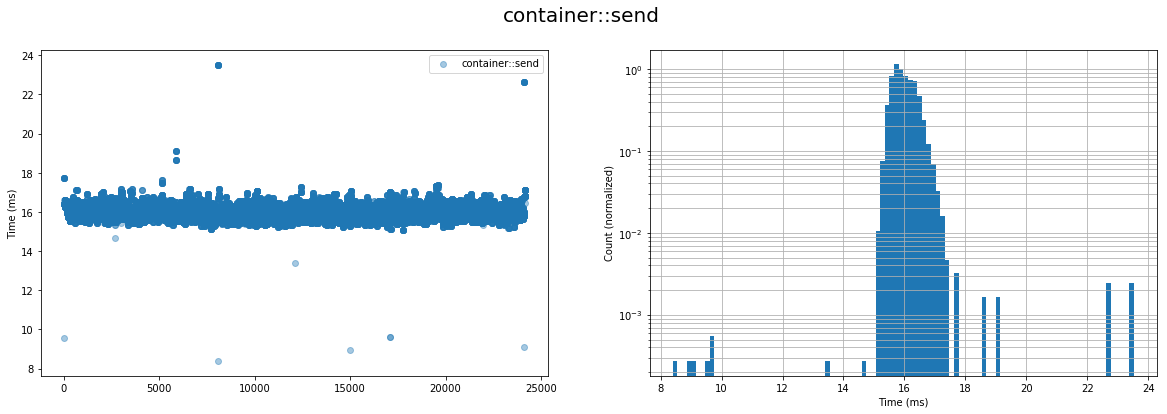

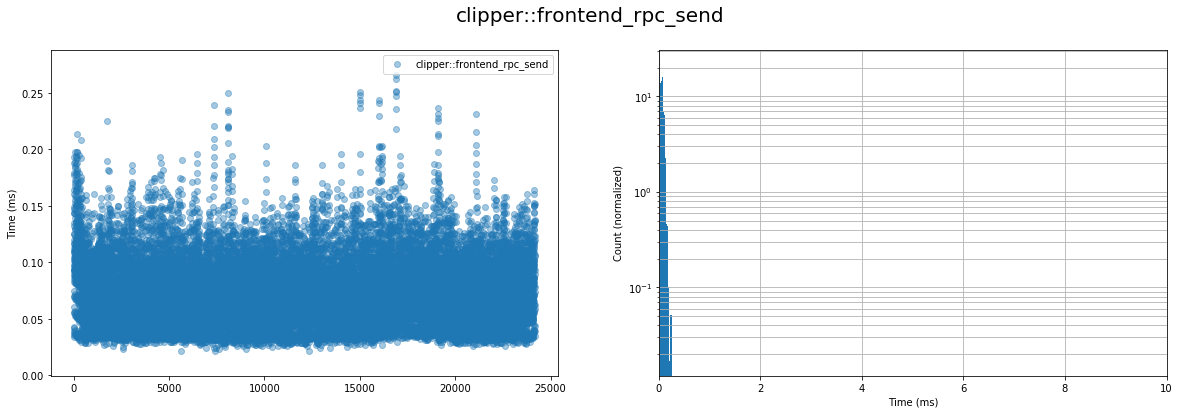

# Model: batch-24-180316_164631.json, Batch size: 24

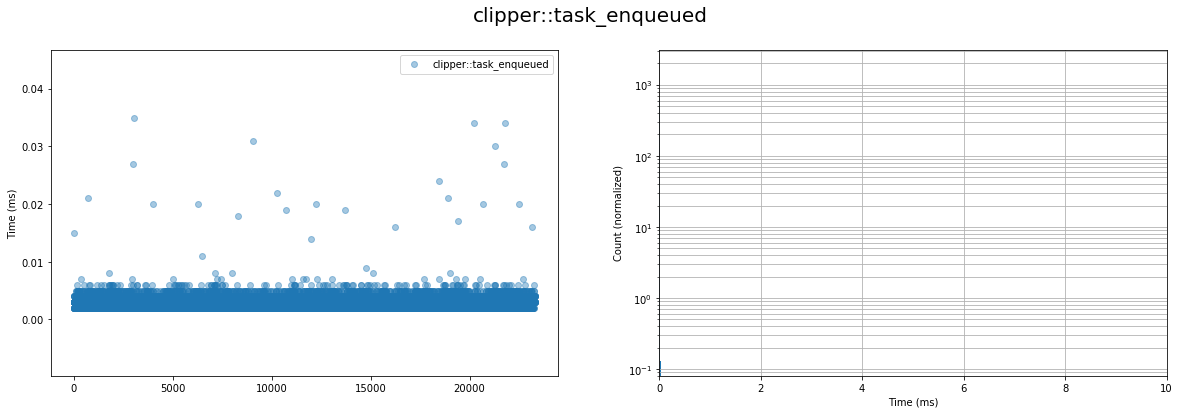

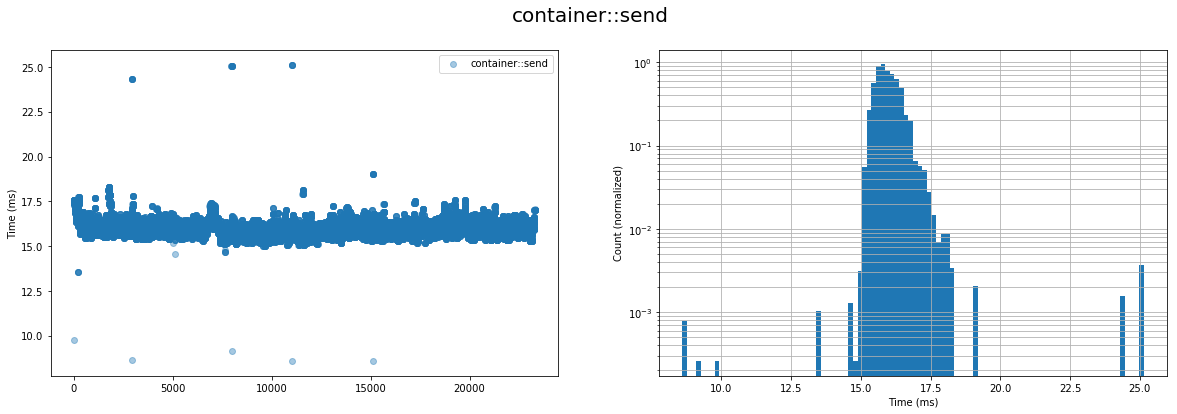

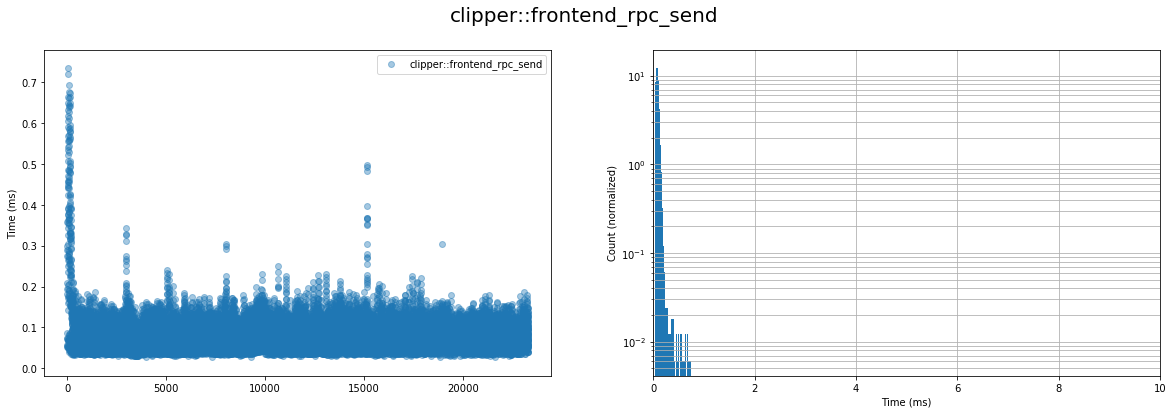

# Model: batch-32-180316_170847.json, Batch size: 32

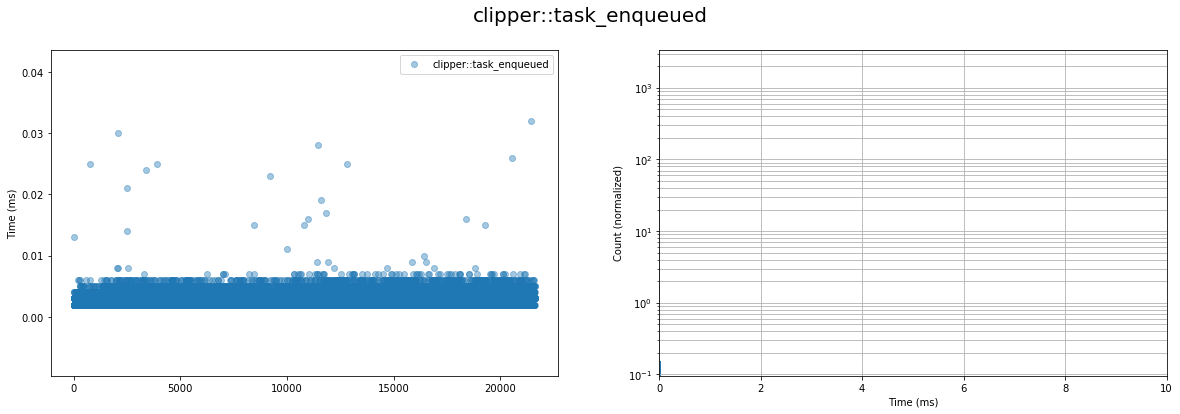

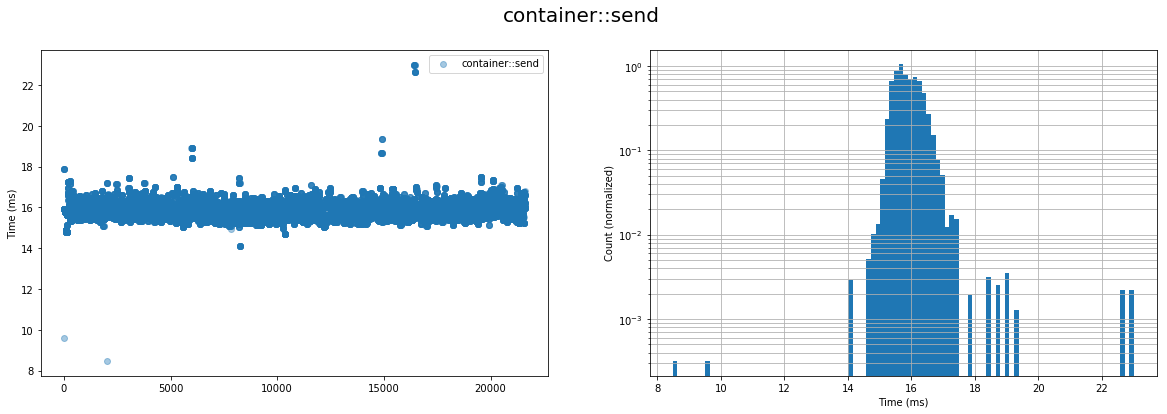

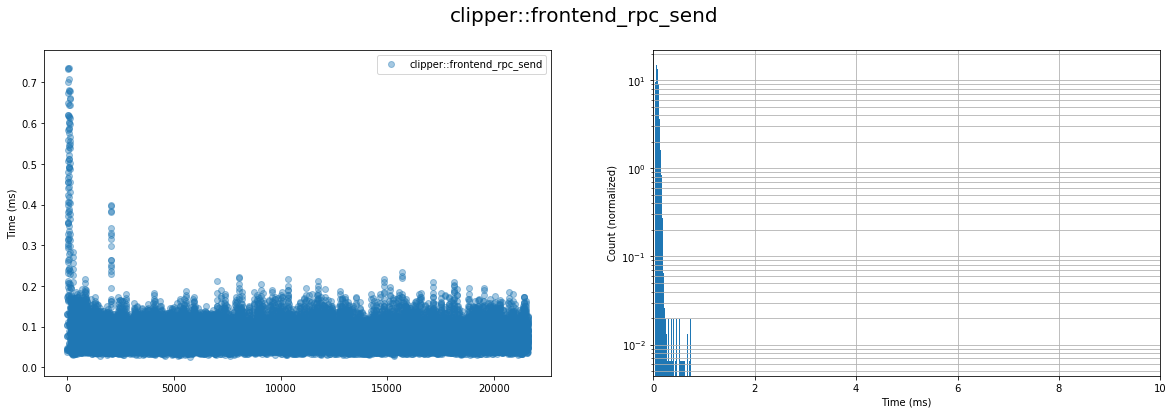

# Model: batch-4-180316_082855.json, Batch size: 4

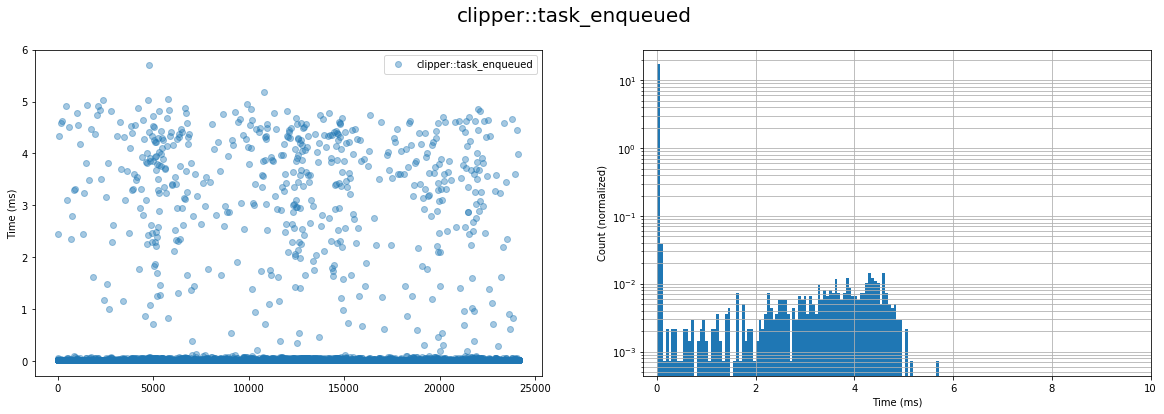

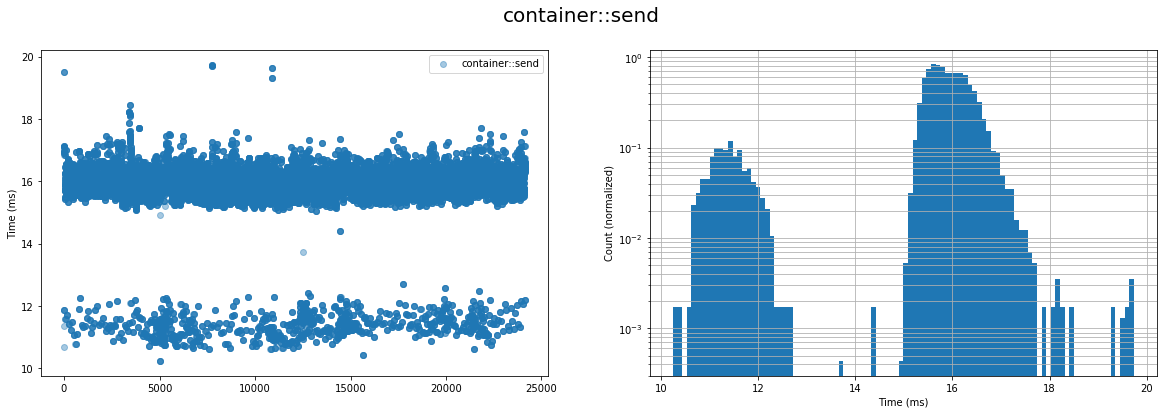

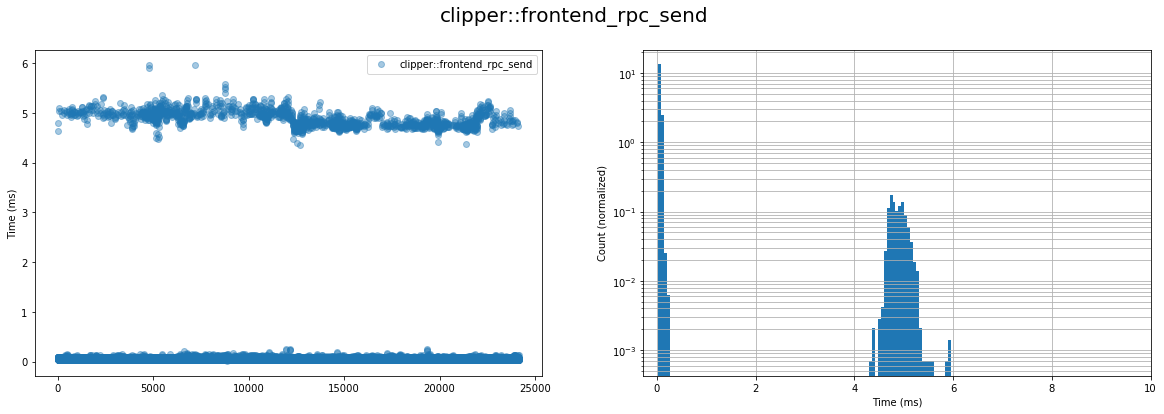

# Model: batch-48-180316_173028.json, Batch size: 48

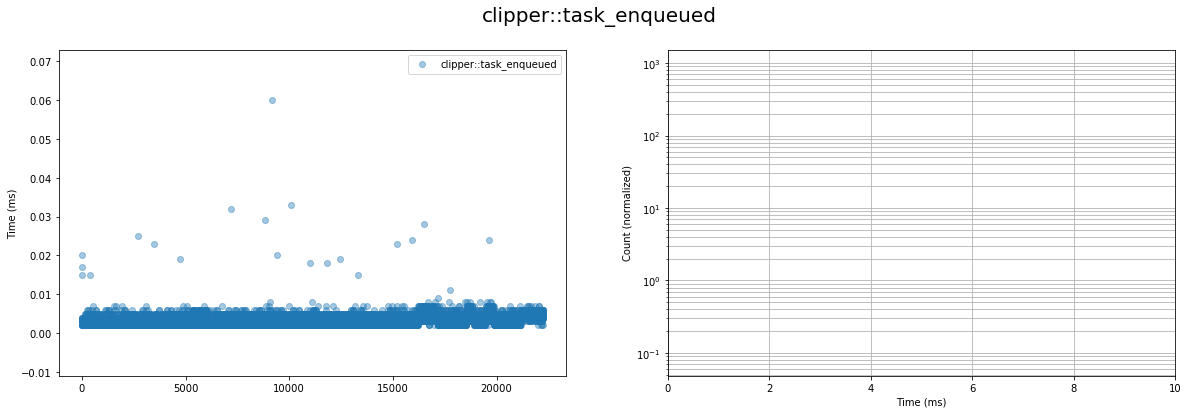

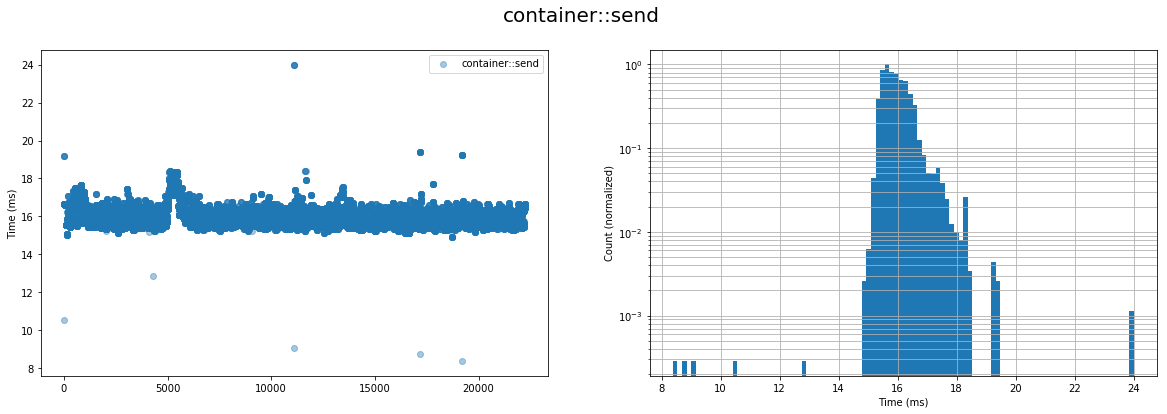

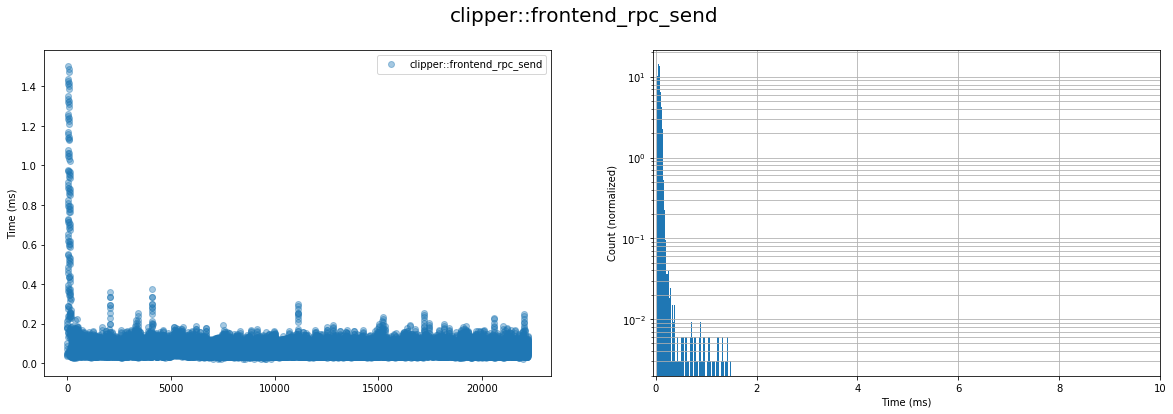

# Model: batch-64-180316_175138.json, Batch size: 64

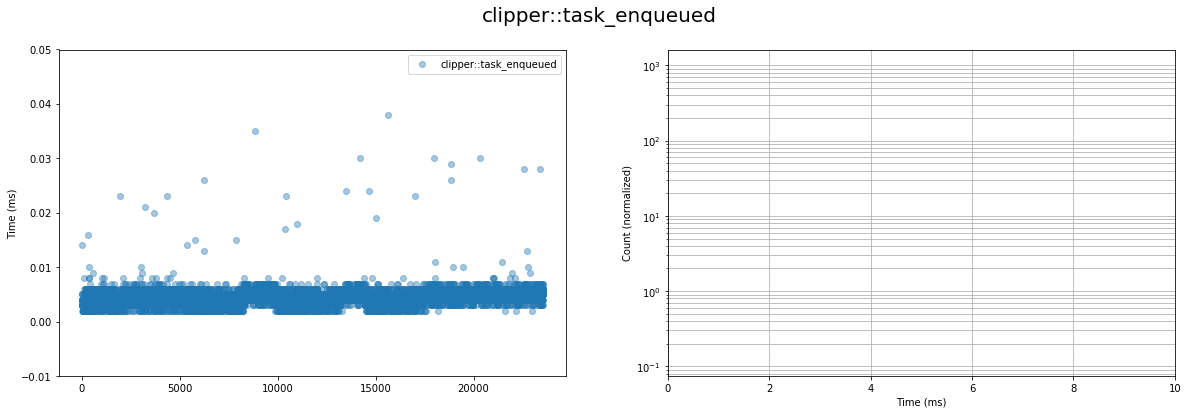

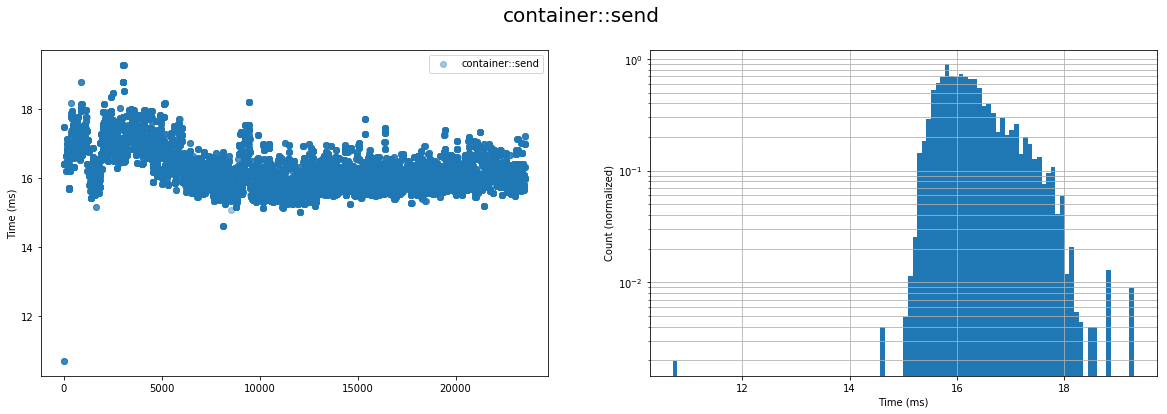

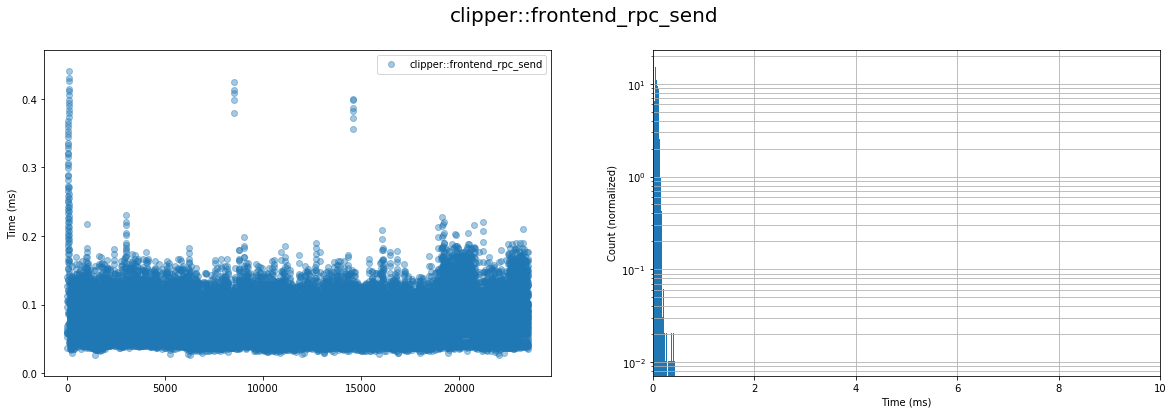

# Model: batch-8-180316_155807.json, Batch size: 8

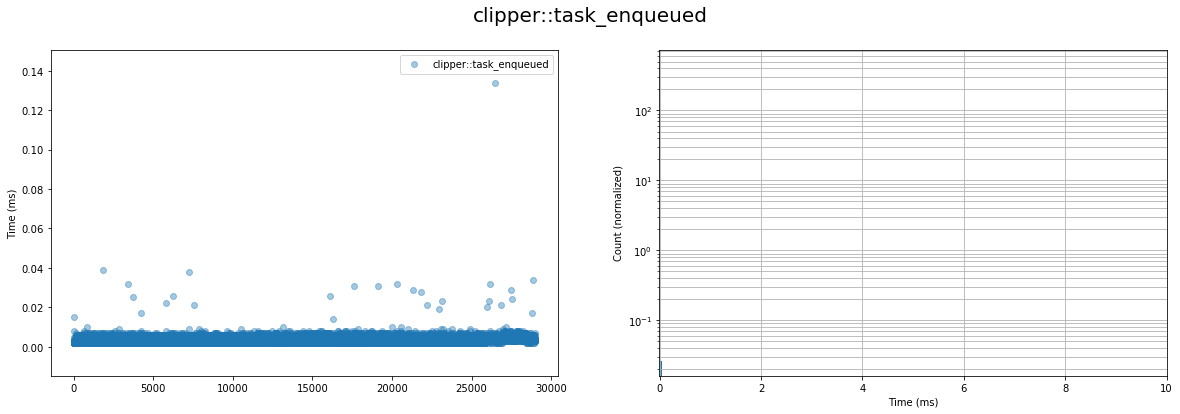

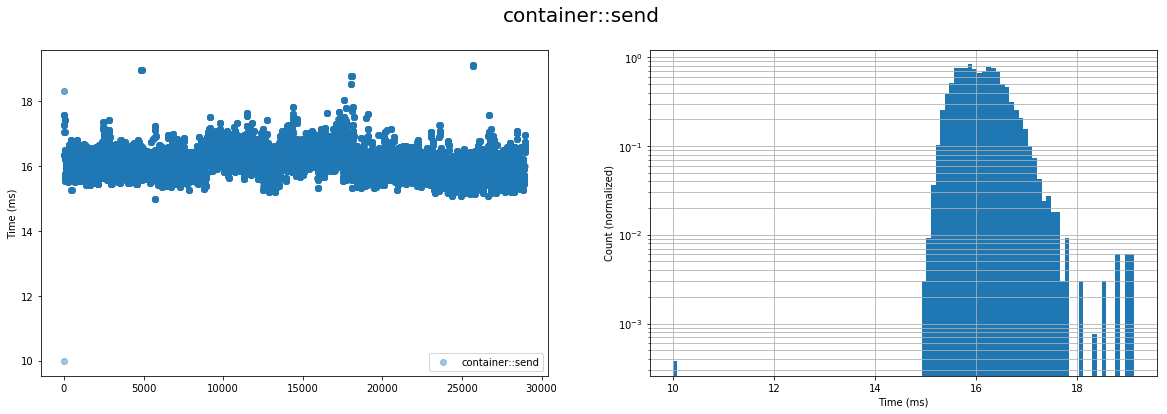

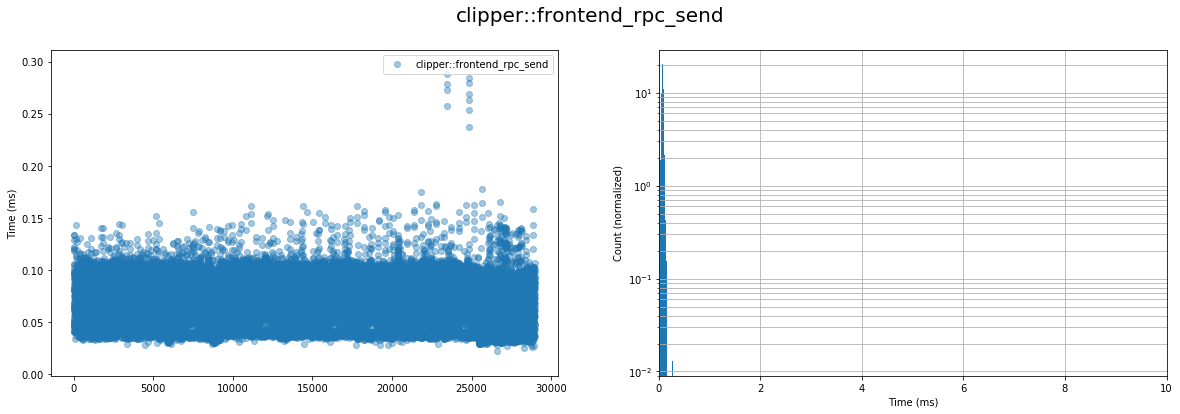

In [7]:
path = os.path.abspath("../results_cpp_benchmarker/query_lineage/query_lineage_tf-kernel-svm_smp_aws_cpp_profiling/")
analyze_dir(path)